In [2]:
##Synthetic_Data_concetinatioon

Loaded old IID results from FL_VEHICLE/cnn2_128_500_vehicle_rgb_sgd.csv
Path to dataset files: C:\Users\hp\.cache\kagglehub\datasets\sujaykapadnis\vehicle-type-image-dataset\versions\1
Inspecting dataset path: C:\Users\hp\.cache\kagglehub\datasets\sujaykapadnis\vehicle-type-image-dataset\versions\1
Root: C:\Users\hp\.cache\kagglehub\datasets\sujaykapadnis\vehicle-type-image-dataset\versions\1
Dirs: ['Vehicle Type Image Dataset (Version 2) VTID2']
Files (first 5): []
--------------------------------------------------
Root: C:\Users\hp\.cache\kagglehub\datasets\sujaykapadnis\vehicle-type-image-dataset\versions\1\Vehicle Type Image Dataset (Version 2) VTID2
Dirs: ['Hatchback', 'Other', 'Pickup', 'Seden', 'SUV']
Files (first 5): []
--------------------------------------------------
Root: C:\Users\hp\.cache\kagglehub\datasets\sujaykapadnis\vehicle-type-image-dataset\versions\1\Vehicle Type Image Dataset (Version 2) VTID2\Hatchback
Dirs: []
Files (first 5): ['PHOTO_0.jpg', 'PHOTO_1.jpg', 'PH

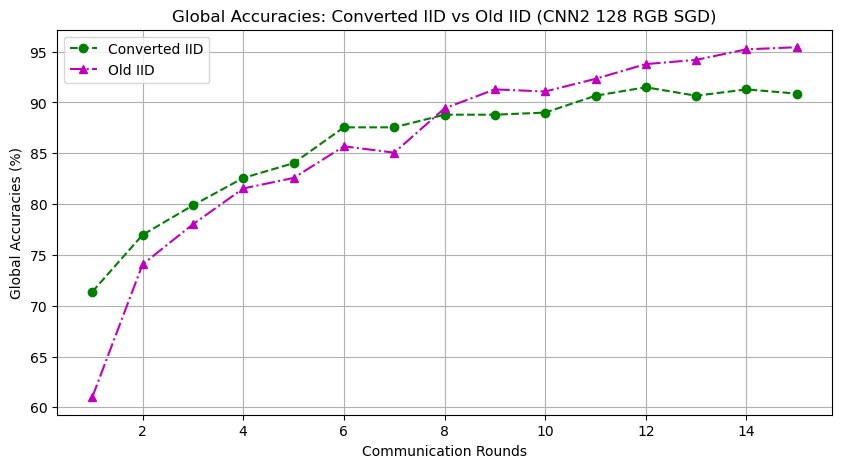

Saved accuracy comparison plot to FL_VEHICLE_CONVERTED_IID\cnn2_128_500_vehicle_rgb_sgd_accuracy_converted_iid_vs_old_iid.png


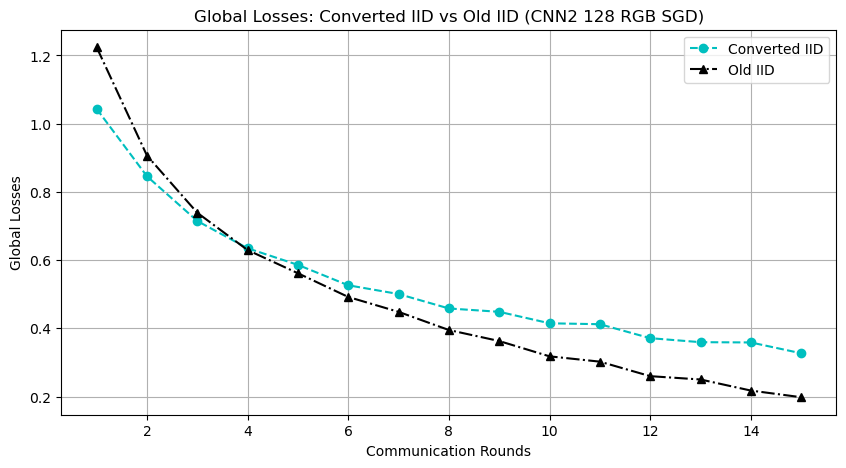

Saved loss comparison plot to FL_VEHICLE_CONVERTED_IID\cnn2_128_500_vehicle_rgb_sgd_loss_converted_iid_vs_old_iid.png


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import math
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset, ConcatDataset
import torchvision.datasets as datasets
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import os
import numpy as np
from PIL import Image
import csv
import random
import kagglehub
from sklearn.model_selection import train_test_split
from torchvision.transforms import ToPILImage
import pandas as pd

# Ensure output directory exists for converted IID
output_dir_converted_iid = "FL_VEHICLE_CONVERTED_IID"
os.makedirs(output_dir_converted_iid, exist_ok=True)

# Load the old IID results
old_iid_data_path = "FL_VEHICLE/cnn2_128_500_vehicle_rgb_sgd.csv"
try:
    old_iid_df = pd.read_csv(old_iid_data_path)
    communication_rounds_old_iid = old_iid_df['Communication Rounds'].tolist()
    global_accuracies_old_iid = old_iid_df['Global Accuracies'].tolist()
    global_losses_old_iid = old_iid_df['Global Losses'].tolist()
    print(f"Loaded old IID results from {old_iid_data_path}")
except Exception as e:
    print(f"Failed to load old IID results from {old_iid_data_path}: {e}")
    raise

# Download Vehicle Type Image Dataset from Kaggle
try:
    path = kagglehub.dataset_download("sujaykapadnis/vehicle-type-image-dataset")
    print("Path to dataset files:", path)
    dataset_path = path
except Exception as e:
    print(f"Failed to download dataset: {e}")
    raise

# Path to synthetic data
synthetic_data_path = r"C:\Users\hp\Desktop\fedavg\top_500_images_per_class"

# Base transform for RGB Vehicle Type Dataset
base_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Debug dataset directory structure
print("Inspecting dataset path:", dataset_path)
for root, dirs, files in os.walk(dataset_path):
    print(f"Root: {root}")
    print(f"Dirs: {dirs}")
    print(f"Files (first 5): {files[:5]}")
    print("-" * 50)

# Custom Dataset for the Original Vehicle Type Dataset
class VehicleTypeDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.class_names = []
        self.class_to_idx = {}

        print(f"Searching for images in {root_dir}")
        for root, dirs, files in os.walk(root_dir):
            image_files = [f for f in files if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
            if image_files:
                class_name = os.path.basename(root)
                if class_name not in self.class_to_idx:
                    self.class_names.append(class_name)
                    self.class_to_idx[class_name] = len(self.class_names) - 1
                for img_file in image_files:
                    img_path = os.path.join(root, img_file)
                    self.images.append(img_path)
                    self.labels.append(self.class_to_idx[class_name])

        if not self.images:
            raise ValueError(f"No images found in {root_dir}.")

        print(f"Found {len(self.images)} images across {len(self.class_names)} classes.")
        print(f"Classes: {self.class_names}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Custom Dataset for Synthetic Data
class SyntheticVehicleDataset(Dataset):
    def __init__(self, root_dir, class_idx, transform=None):
        self.root_dir = root_dir
        self.class_idx = class_idx
        self.transform = transform
        self.images = []

        class_dir = os.path.join(root_dir, str(class_idx))
        if not os.path.exists(class_dir):
            raise ValueError(f"Class directory {class_dir} does not exist.")

        image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
        for img_file in image_files:
            img_path = os.path.join(class_dir, img_file)
            self.images.append(img_path)

        if len(self.images) != 500:
            print(f"Warning: Expected 500 synthetic images for class {class_idx}, found {len(self.images)}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.class_idx
        if self.transform:
            image = self.transform(image)
        return image, label

# Load the Vehicle Type Dataset without transformations for splitting
dataset_no_transform = VehicleTypeDataset(root_dir=dataset_path, transform=None)

# Update label_dim
label_dim = len(dataset_no_transform.class_names)
print(f"Number of classes (label_dim): {label_dim}")

# Step 1: Split dataset into train, validation, and test sets per class
validation_ratio = 0.1
test_ratio = 0.1
train_ratio = 0.8

class_datasets = [[] for _ in range(label_dim)]
for idx in range(len(dataset_no_transform)):
    label = dataset_no_transform.labels[idx]
    class_datasets[label].append(idx)

train_indices_per_class = []
val_indices_per_class = []
test_indices_per_class = []

for class_idx in range(label_dim):
    indices = class_datasets[class_idx]
    total_samples = len(indices)
    num_train = int(total_samples * train_ratio)
    num_val = int(total_samples * validation_ratio)
    num_test = total_samples - num_train - num_val

    random.shuffle(indices)

    train_indices = indices[:num_train]
    val_indices = indices[num_train:num_train + num_val]
    test_indices = indices[num_train + num_val:]

    train_indices_per_class.append(train_indices)
    val_indices_per_class.append(val_indices)
    test_indices_per_class.append(test_indices)

    print(f"Class {class_idx}: Train={len(train_indices)}, Val={len(val_indices)}, Test={len(test_indices)}")

# Verify no overlap between train, val, and test
for class_idx in range(label_dim):
    train_set = set(train_indices_per_class[class_idx])
    val_set = set(val_indices_per_class[class_idx])
    test_set = set(test_indices_per_class[class_idx])
    assert len(train_set.intersection(val_set)) == 0, f"Overlap between train and val for class {class_idx}"
    assert len(train_set.intersection(test_set)) == 0, f"Overlap between train and test for class {class_idx}"
    assert len(val_set.intersection(test_set)) == 0, f"Overlap between val and test for class {class_idx}"

# Create datasets with transformations
dataset = VehicleTypeDataset(root_dir=dataset_path, transform=base_transform)
val_dataset = Subset(dataset, [idx for class_indices in val_indices_per_class for idx in class_indices])
test_dataset = Subset(dataset, [idx for class_indices in test_indices_per_class for idx in class_indices])

print(f"Validation samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")

# Step 2: Define augmentation transforms
augmentation_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
])

def augment_image_if_needed(image):
    if isinstance(image, torch.Tensor):
        image = ToPILImage()(image)
    image = augmentation_transform(image)
    image = base_transform(image)
    return image

# Step 3: Distribute training data to users (non-IID initially as a step to convert to IID)
Num_users = 5
target_samples_per_class_per_user = 500
user_data_non_iid = [[] for _ in range(Num_users)]
user_indices_sets_non_iid = [[] for _ in range(Num_users)]

desired_sample_counts = [
    {0: 241, 3: 72, 4: 169, 1: 0, 2: 0},  # Class 0
    {0: 168, 1: 240, 4: 72, 2: 0, 3: 0},  # Class 1
    {0: 203, 1: 473, 2: 675, 3: 0, 4: 0},  # Class 2
    {1: 117, 2: 274, 3: 391, 0: 0, 4: 0},  # Class 3
    {2: 65, 3: 152, 4: 218, 0: 0, 1: 0},  # Class 4
]

samples_before_after_non_iid = {user_idx: {class_idx: {'before': 0, 'after': 0} for class_idx in range(label_dim)} for user_idx in range(Num_users)}

for class_idx in range(label_dim):
    class_train_indices = train_indices_per_class[class_idx]
    total_class_train_samples = len(class_train_indices)
    random.shuffle(class_train_indices)

    user_sample_counts = desired_sample_counts[class_idx]
    assigned_samples = sum(user_sample_counts.values())
    if assigned_samples != total_class_train_samples:
        print(f"Warning: Assigned samples ({assigned_samples}) for Class {class_idx} do not match total ({total_class_train_samples})")

    start_idx = 0
    for user_idx in range(Num_users):
        num_samples = user_sample_counts.get(user_idx, 0)
        if num_samples == 0:
            print(f"User {user_idx + 1}, Class {class_idx} ({dataset.class_names[class_idx]}): 0 samples")
            samples_before_after_non_iid[user_idx][class_idx]['before'] = 0
            samples_before_after_non_iid[user_idx][class_idx]['after'] = 0
            continue

        end_idx = start_idx + num_samples
        user_class_indices = class_train_indices[start_idx:end_idx]
        start_idx = end_idx

        user_class_dataset = Subset(dataset, user_class_indices)
        user_indices_sets_non_iid[user_idx].extend(user_class_indices)

        samples_before_after_non_iid[user_idx][class_idx]['before'] = num_samples

        current_length = len(user_class_dataset)
        num_samples_to_augment = target_samples_per_class_per_user - current_length

        if num_samples_to_augment <= 0:
            user_class_indices = user_class_indices[:target_samples_per_class_per_user]
            user_class_dataset = Subset(dataset, user_class_indices)
            user_data_non_iid[user_idx].append(user_class_dataset)
            samples_before_after_non_iid[user_idx][class_idx]['after'] = len(user_class_dataset)
            print(f"User {user_idx + 1}, Class {class_idx} ({dataset.class_names[class_idx]}): {len(user_class_dataset)} samples (Original: {num_samples})")
            continue

        augmented_samples = []
        original_indices = list(range(current_length))
        random.shuffle(original_indices)
        idx_counter = 0

        for _ in range(num_samples_to_augment):
            orig_idx = original_indices[idx_counter % current_length]
            idx_counter += 1
            image, label = user_class_dataset[orig_idx]
            augmented_image = augment_image_if_needed(image)
            augmented_samples.append((augmented_image, label))

        augmented_dataset = ConcatDataset([user_class_dataset, augmented_samples])
        user_data_non_iid[user_idx].append(augmented_dataset)
        samples_before_after_non_iid[user_idx][class_idx]['after'] = len(augmented_dataset)
        print(f"User {user_idx + 1}, Class {class_idx} ({dataset.class_names[class_idx]}): {len(augmented_dataset)} samples (Original: {num_samples})")

# Combine datasets for each user (non-IID as a step to convert to IID)
for user_idx in range(Num_users):
    user_data_non_iid[user_idx] = ConcatDataset(user_data_non_iid[user_idx])
    print(f"User {user_idx + 1} (Non-IID intermediate): Total samples = {len(user_data_non_iid[user_idx])}")

# Step 4: Convert non-IID to IID by adding synthetic data for missing classes
user_data_converted_iid = [[] for _ in range(Num_users)]
user_indices_sets_converted_iid = [[] for _ in range(Num_users)]
samples_before_after_converted_iid = {user_idx: {class_idx: {'before': 0, 'after': 0} for class_idx in range(label_dim)} for user_idx in range(Num_users)}

missing_classes = {
    0: [3, 4],  # User 1 missing classes 3, 4
    1: [0, 4],  # User 2 missing classes 0, 4
    2: [0, 1],  # User 3 missing classes 0, 1
    3: [1, 2],  # User 4 missing classes 1, 2
    4: [2, 3]   # User 5 missing classes 2, 3
}

for user_idx in range(Num_users):
    user_data_converted_iid[user_idx] = user_data_non_iid[user_idx].datasets
    user_indices_sets_converted_iid[user_idx] = user_indices_sets_non_iid[user_idx].copy()
    
    for class_idx in range(label_dim):
        samples_before_after_converted_iid[user_idx][class_idx]['before'] = samples_before_after_non_iid[user_idx][class_idx]['before']
        samples_before_after_converted_iid[user_idx][class_idx]['after'] = samples_before_after_non_iid[user_idx][class_idx]['after']

    for class_idx in missing_classes[user_idx]:
        print(f"Adding 500 synthetic samples for User {user_idx + 1}, Class {class_idx} ({dataset.class_names[class_idx]})")
        synthetic_dataset = SyntheticVehicleDataset(root_dir=synthetic_data_path, class_idx=class_idx, transform=base_transform)
        user_data_converted_iid[user_idx].append(synthetic_dataset)
        samples_before_after_converted_iid[user_idx][class_idx]['before'] = 0
        samples_before_after_converted_iid[user_idx][class_idx]['after'] = len(synthetic_dataset)
        print(f"User {user_idx + 1}, Class {class_idx} ({dataset.class_names[class_idx]}): Added {len(synthetic_dataset)} synthetic samples")

for user_idx in range(Num_users):
    user_data_converted_iid[user_idx] = ConcatDataset(user_data_converted_iid[user_idx])
    print(f"User {user_idx + 1} (Converted IID): Total samples = {len(user_data_converted_iid[user_idx])}")

# Step 5: Verify Converted IID Distribution
print("\n=== Verifying Converted IID Data Distribution Across Users ===")
class_counts_per_user_converted_iid = []
for user_idx in range(Num_users):
    user_dataset = user_data_converted_iid[user_idx]
    class_counts = [0] * label_dim
    for idx in range(len(user_dataset)):
        _, label = user_dataset[idx]
        class_counts[label] += 1
    class_counts_per_user_converted_iid.append(class_counts)
    print(f"User {user_idx + 1} (Converted IID) Class Distribution: {class_counts}")
    total_samples = len(user_dataset)
    class_percentages = [count / total_samples * 100 if total_samples > 0 else 0 for count in class_counts]
    print(f"User {user_idx + 1} (Converted IID) Class Percentages: {[f'{p:.2f}%' for p in class_percentages]}")

print("\n=== Class Proportion Variance Across Users (Converted IID) ===")
class_percentages_all_users_converted_iid = np.array([[count / sum(counts) * 100 for count in counts] for counts in class_counts_per_user_converted_iid])
for class_idx in range(label_dim):
    class_proportions = class_percentages_all_users_converted_iid[:, class_idx]
    variance = np.var(class_proportions)
    print(f"Class {class_idx} proportion variance across users (Converted IID): {variance:.2f}%")
    if variance > 5:
        print(f"Warning: High variance in Class {class_idx} distribution (should be low for IID).")

# CNN Model for RGB
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1, stride=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, label_dim)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Step 6: Run Federated Learning for Converted IID Setup Only
device = torch.device('cuda:1' if torch.cuda.device_count() > 1 else 'cuda')
batch_size = 128
num_local_epochs = 3
num_rounds = 15

print("\n=== Running Federated Learning (Converted IID) ===")
global_model_converted_iid = CNN().to(device)
local_models_converted_iid = [CNN().to(device) for _ in range(Num_users)]
communication_rounds_converted_iid = []
global_accuracies_converted_iid = []
global_losses_converted_iid = []

for round in range(num_rounds):
    print(f"Round {round + 1} (Converted IID)")
    for user_idx in range(Num_users):
        local_models_converted_iid[user_idx].load_state_dict(global_model_converted_iid.state_dict())
        local_model = local_models_converted_iid[user_idx]
        local_tr_data_loader = DataLoader(user_data_converted_iid[user_idx], batch_size=batch_size, shuffle=True)
        local_val_data_loader = DataLoader(val_dataset, batch_size=batch_size)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(local_model.parameters(), lr=0.001, momentum=0.9)
        scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

        for epoch in range(num_local_epochs):
            local_model.train()
            running_loss = 0.0
            correct_train = 0
            total_train = 0
            for data, target in local_tr_data_loader:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = local_model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                _, predicted = output.max(1)
                total_train += target.size(0)
                correct_train += predicted.eq(target).sum().item()

            train_loss = running_loss / len(local_tr_data_loader) if len(local_tr_data_loader) > 0 else float('inf')
            train_accuracy = 100 * correct_train / total_train if total_train > 0 else 0.0

            local_model.eval()
            val_loss = 0.0
            correct_val = 0
            total_val = 0
            with torch.no_grad():
                for data, target in local_val_data_loader:
                    data, target = data.to(device), target.to(device)
                    output = local_model(data)
                    val_loss += criterion(output, target).item()
                    _, predicted = output.max(1)
                    total_val += target.size(0)
                    correct_val += predicted.eq(target).sum().item()

            val_loss /= len(local_val_data_loader) if len(local_val_data_loader) > 0 else 1
            val_accuracy = 100 * correct_val / total_val if total_val > 0 else 0.0
            print(f"User {user_idx + 1}, Epoch {epoch + 1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                  f"Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%")
            scheduler.step()

    global_state_dict = global_model_converted_iid.state_dict()
    for key in global_state_dict.keys():
        local_state_dicts = [local_model.state_dict() for local_model in local_models_converted_iid]
        global_state_dict[key] = torch.mean(torch.stack([d[key].float() for d in local_state_dicts]), dim=0)
    global_model_converted_iid.load_state_dict(global_state_dict)

    global_model_converted_iid.eval()
    global_loss = 0.0
    global_accuracy = 0.0
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = global_model_converted_iid(data)
            global_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs, 1)
            global_accuracy += (predicted == labels).sum().item()

    global_accuracy = 100 * global_accuracy / len(test_dataset) if len(test_dataset) > 0 else 0.0
    global_loss /= len(test_loader) if len(test_loader) > 0 else 1
    print(f"Round {round + 1}: Global Test Accuracy (Converted IID): {global_accuracy:.2f}%, Global Loss: {global_loss:.4f}")
    communication_rounds_converted_iid.append(round + 1)
    global_accuracies_converted_iid.append(global_accuracy)
    global_losses_converted_iid.append(global_loss)

# Step 7: Save Results for Converted IID and Compare with Old IID
# Save Converted IID Results
model_save_path_converted_iid = os.path.join(output_dir_converted_iid, "cnn2_128_500_rgb_sgd_global_model_converted_iid.pth")
torch.save(global_model_converted_iid.state_dict(), model_save_path_converted_iid)
print(f"Converted IID global model saved to {model_save_path_converted_iid}")

csv_file_path_converted_iid = os.path.join(output_dir_converted_iid, "cnn2_128_500_vehicle_rgb_sgd_converted_iid.csv")
with open(csv_file_path_converted_iid, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Communication Rounds', 'Global Accuracies', 'Global Losses'])
    writer.writerows(zip(communication_rounds_converted_iid, global_accuracies_converted_iid, global_losses_converted_iid))

# Compare Converted IID and Old IID: Accuracy Plot
plt.figure(figsize=(10, 5))
plt.plot(communication_rounds_converted_iid, global_accuracies_converted_iid, marker='o', linestyle='--', color='g', label='Converted IID')
plt.plot(communication_rounds_old_iid, global_accuracies_old_iid, marker='^', linestyle='-.', color='m', label='Old IID')
plt.xlabel('Communication Rounds')
plt.ylabel('Global Accuracies (%)')
plt.title('Global Accuracies: Converted IID vs Old IID (CNN2 128 RGB SGD)')
plt.grid(True)
plt.legend()
comparison_accuracy_plot = os.path.join(output_dir_converted_iid, "cnn2_128_500_vehicle_rgb_sgd_accuracy_converted_iid_vs_old_iid.png")
plt.savefig(comparison_accuracy_plot)
plt.show()
print(f"Saved accuracy comparison plot to {comparison_accuracy_plot}")

# Compare Converted IID and Old IID: Loss Plot
plt.figure(figsize=(10, 5))
plt.plot(communication_rounds_converted_iid, global_losses_converted_iid, marker='o', linestyle='--', color='c', label='Converted IID')
plt.plot(communication_rounds_old_iid, global_losses_old_iid, marker='^', linestyle='-.', color='k', label='Old IID')
plt.xlabel('Communication Rounds')
plt.ylabel('Global Losses')
plt.title('Global Losses: Converted IID vs Old IID (CNN2 128 RGB SGD)')
plt.grid(True)
plt.legend()
comparison_loss_plot = os.path.join(output_dir_converted_iid, "cnn2_128_500_vehicle_rgb_sgd_loss_converted_iid_vs_old_iid.png")
plt.savefig(comparison_loss_plot)
plt.show()
print(f"Saved loss comparison plot to {comparison_loss_plot}")